In [1]:
project_root = '../demo/case1-reaching-task/'

video_path = f'{project_root}reaching-task-raw.mp4'
out1_path = f'{project_root}reaching-task-raw-mix.mp4'
out2_path = f'{project_root}reaching-task-raw-mask.mp4'
crf = 18

label_path_list = [f'{project_root}frame0-label.npz',
                   f'{project_root}frame247-label.npz']



ckpt_path = '../ckpt/R50_DeAOTL_PRE_YTB_DAV.pth'
MODEL = 'r50_deaotl'
DEVICE = 'cuda' # cuda, mps


In [2]:
import cv2
from tqdm import tqdm
import numpy as np
from castle import generate_aot
from castle.utils.plot import generate_mix_image, generate_mask_image

In [3]:
tracker = generate_aot(ckpt_path, MODEL, DEVICE)
frames = [np.load(it)['frame'] for it in label_path_list]
masks = [np.load(it)['mask'] for it in label_path_list]

num_object = np.max(masks[0]) # 1
print('num_object:', num_object)

tracker.add_reference_frame(frames[0], masks[0], num_object)
tracker.add_reference_frame(frames[1], masks[1], num_object)

AOTTracker Device: cuda
num_object: 1


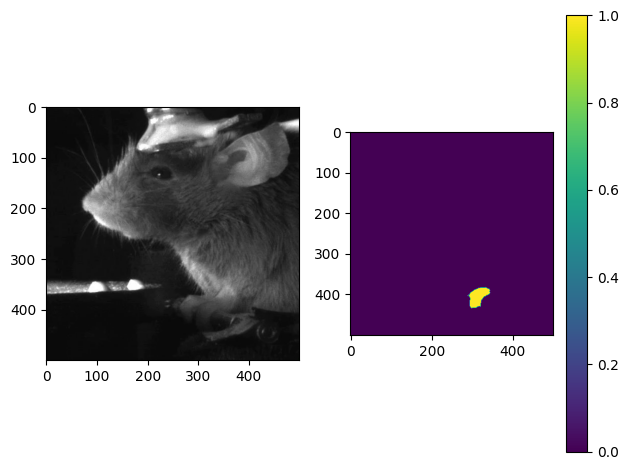

In [6]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.imshow(frames[0])
plt.subplot(1,2,2)
plt.imshow(masks[0])
plt.colorbar()
plt.tight_layout()
plt.show()
plt.close()

In [4]:


# 載入影片
cap = cv2.VideoCapture(video_path)

# 檢查影片是否成功打開
if not cap.isOpened():
    print("Error opening video file")
    exit(1)

# 獲取影片的基本參數
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# 設置輸出影片的格式和名稱
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 使用 mp4v 編碼
out = cv2.VideoWriter(out1_path, fourcc, fps, (frame_width, frame_height))
out2 = cv2.VideoWriter(out2_path, fourcc, fps, (frame_width, frame_height))
# 使用 tqdm 來顯示進度條
pbar = tqdm(total=total_frames, desc="Processing Video", unit="frame")

# 讀取影片的每一幀
while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        mask = tracker.track(frame)
        mask = mask.squeeze().detach().cpu().numpy().astype(np.uint8)
        mix_img = generate_mix_image(frame, mask)
        mask_img = generate_mask_image(mask)
        mix_img = cv2.cvtColor(mix_img, cv2.COLOR_RGB2BGR)
        mask_img = cv2.cvtColor(mask_img, cv2.COLOR_RGB2BGR)
        out.write(mix_img)
        out2.write(mask_img)
        pbar.update(1)
    else:
        break


cap.release()
out.release()
out2.release()
pbar.close()


Processing Video: 100%|██████████| 480/480 [00:14<00:00, 33.24frame/s]
